# Clasificador de datos que permita reconocer la marcha - Validación Cruzada

**Experimiento con multiples clasificadores y seleccionadores/transformadores con Validación cruzada. Sin usar redes neuronales aún, lo más cercano a eso es MLP, Perceptron, Logistic Regression.**

Divido los datos en K subconjuntos y uso cada uno de ellos como un conjunto de prueba, mientras entrena los K-1 restantes. Se repite K veces y el accuracy se promedia para obtener una estimación más robusta del accuracy del modelo.

- Josefa Fernández

## 0. Initial Setup (carga de libreriías)

In [1]:
# Actualizar ciervo
! pip install ciervo --upgrade


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

fatal: destination path 'balu3' already exists and is not an empty directory.


Processing c:\users\josef\onedrive\escritorio\ciervo\experimentos clasificadores\1era semana\con example_marcha\sin redes neuronales\balu3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=44144 sha256=8da8f8e97c8c299e40e352c5b2ae8460831b919a21fae199de52772b637f9c0f
  Stored in directory: C:\Users\josef\AppData\Local\Temp\pip-ephem-wheel-cache-lfgd9m5o\wheels\56\fb\57\7bcb00acd883955fb059569ca7551f7c5d0c2fd54c4c140f95
Successfully built balu3
  Attempting uninstall: balu3
    Found existing installation: balu3 1.0
    Uninstalling balu3-1.0:
      Successfully uninstalled balu3-1.0



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# ciervo
from ciervo.plots import emg_plot
from ciervo.io import example_marcha

# Manejar señales y otros usos
from scipy import signal
import scipy.signal
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft

#Selection/Transformation
from balu3.fs.sel  import sfs, clean        

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid                           
from sklearn.naive_bayes import GaussianNB                              
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.tree import DecisionTreeClassifier                         
from sklearn.ensemble import RandomForestClassifier                     
from sklearn.linear_model import LogisticRegression      
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis    
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import Perceptron, SGDClassifier 

# validacion cruzada
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold,KFold,LeaveOneOut
from sklearn.preprocessing import MinMaxScaler


## 1. Data Loading

Tomo los archivos de ciervo/tests/data/marcha son 17 archivos

In [4]:
data_files  = example_marcha() # 17 dataframes con data
len(data_files)

17

Ver como se diferencian cada archivo en las señales y datos. Comparo archivo 0 y 1. 

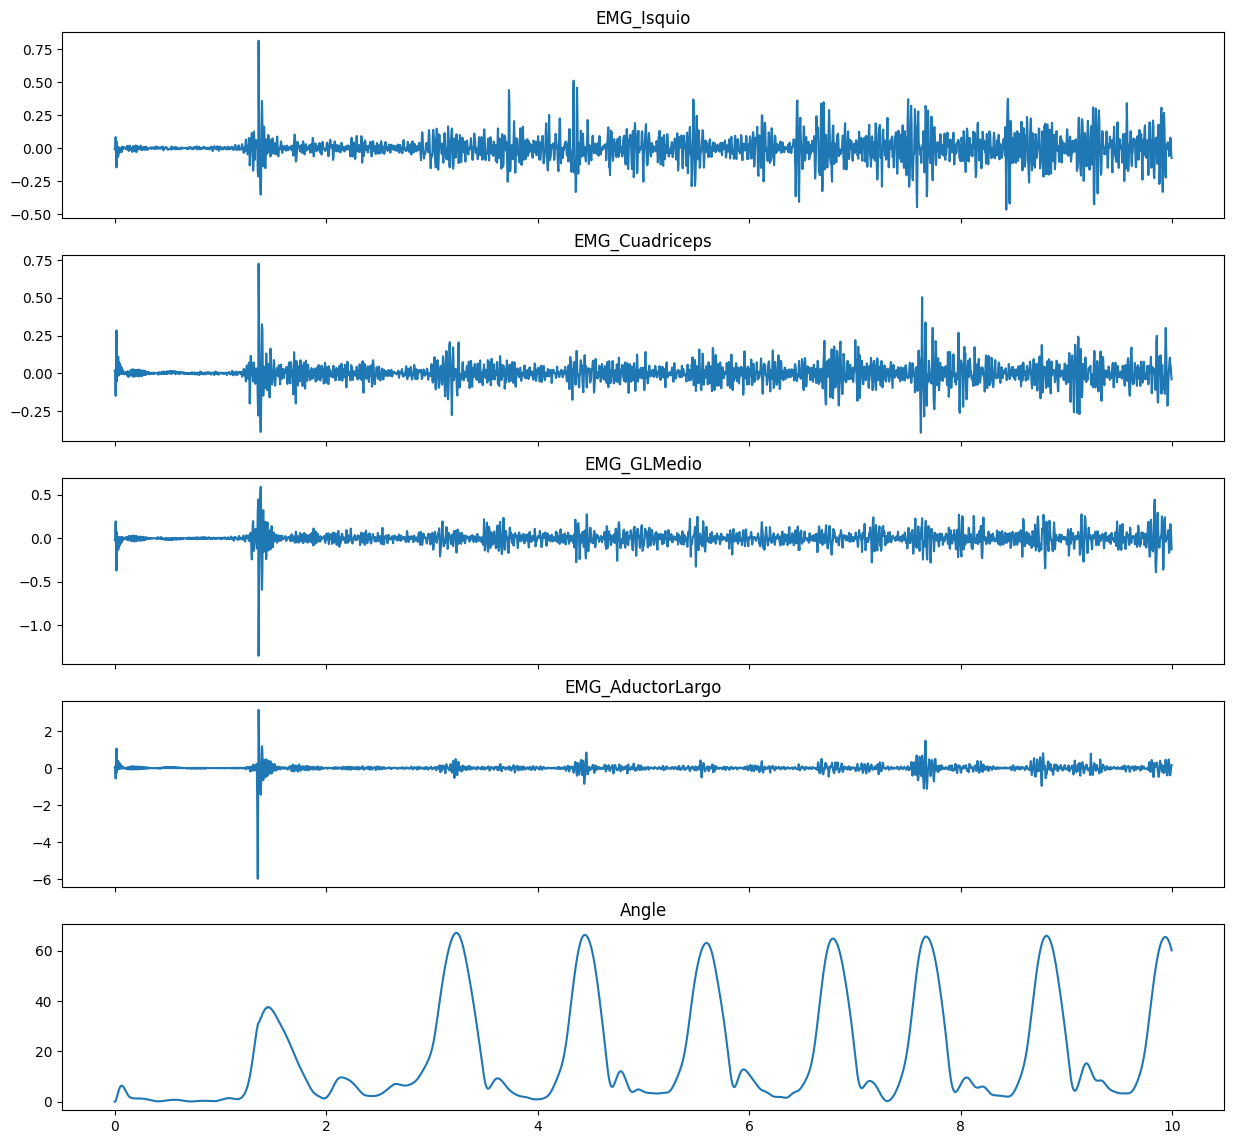

,Elapsed Time,EMG_Isquio,EMG_Cuadriceps,EMG_GLMedio,EMG_AductorLargo,Angle
0,0.000000,-0.007906,0.016890,-0.021607,0.061063,0.000464
1,0.004000,-0.005157,0.014456,-0.022171,0.054785,0.076857
2,0.008000,0.083806,-0.149532,0.195302,-0.559049,0.373102
3,0.012000,-0.059722,0.102592,-0.138364,0.381070,0.811834
4,0.016001,-0.146530,0.284311,-0.371546,1.056500,1.369336


In [5]:
emg_plot(data_files[0])
data_files[0].head()

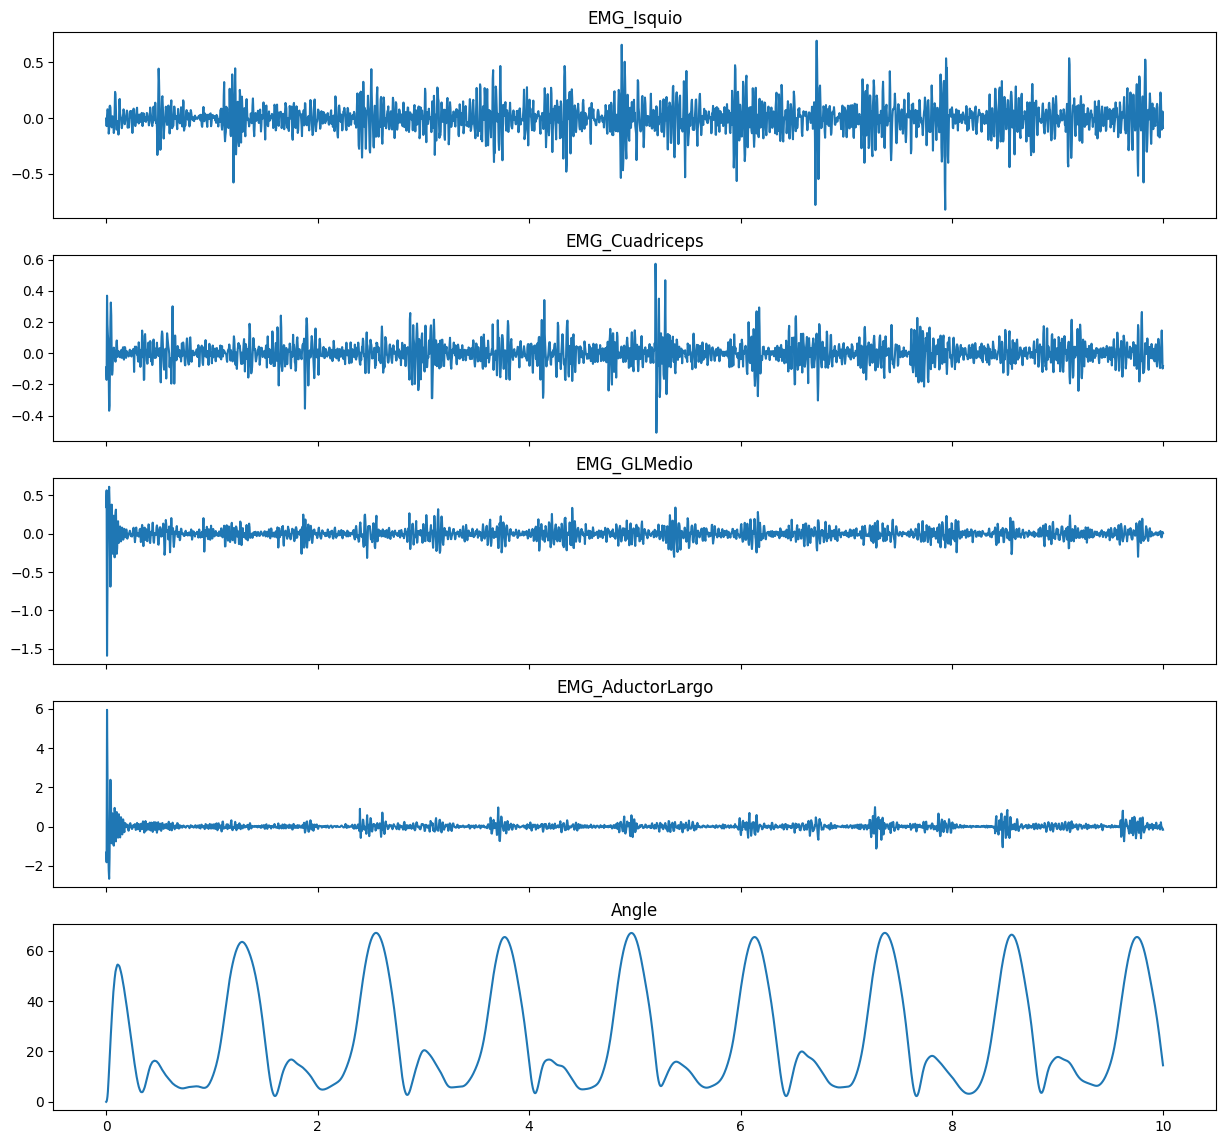

,Elapsed Time,EMG_Isquio,EMG_Cuadriceps,EMG_GLMedio,EMG_AductorLargo,Angle
0,0.000000,-0.004295,-0.091491,0.348355,-1.329848,0.001057
1,0.004000,-0.071835,-0.171336,0.566375,-1.821776,0.175509
2,0.008000,0.020211,0.368513,-1.592143,5.946750,0.883629
3,0.012000,0.078814,0.185123,-0.794130,2.468116,2.083881
4,0.016001,0.074285,0.118401,0.168130,-0.253315,4.010108


In [6]:
emg_plot(data_files[1])
data_files[1].head()

Dataframe en pandas
 
Elapsed Time: Tiempo en segundos 

- **Isquio:** Señal EMG del músculo isquiotibial 
- **Cuadriceps:** Señal EMG del músculo cuádriceps 
- **GLMedio:** Señal EMG del músculo glúteo medio 
- **AductorLargo:** Señal EMG del músculo aductor largo 
- **Angle** 

Se puede observar igual diferencias entre los dos archivos que se supone que se esta realizando el mismo movimiento. 

## 2. Feature Extraction (función extracción caracteristicas del 100% de los datos)

### 2.1. Downsampling and feature extraction from EMG signals

#### 2.1.1. Identifica y visualiza cumbres en señal de angulo de la marcha

Se usa find_peaks para identificar cumbres en la señal de angulo de los datos de marcha. 

Retorna peaks[0], con indices de los picos encontrados en la señal de angulo. Como también se realiza una figura para visualizar las cumbres detectadas, representado con un punto rojo.

[ 808 1112 1399 1698 1918 2203 2484 2761 3029 3263 3511 3772 4049 4317
 4585 4863 5123 5399 5669 5954]


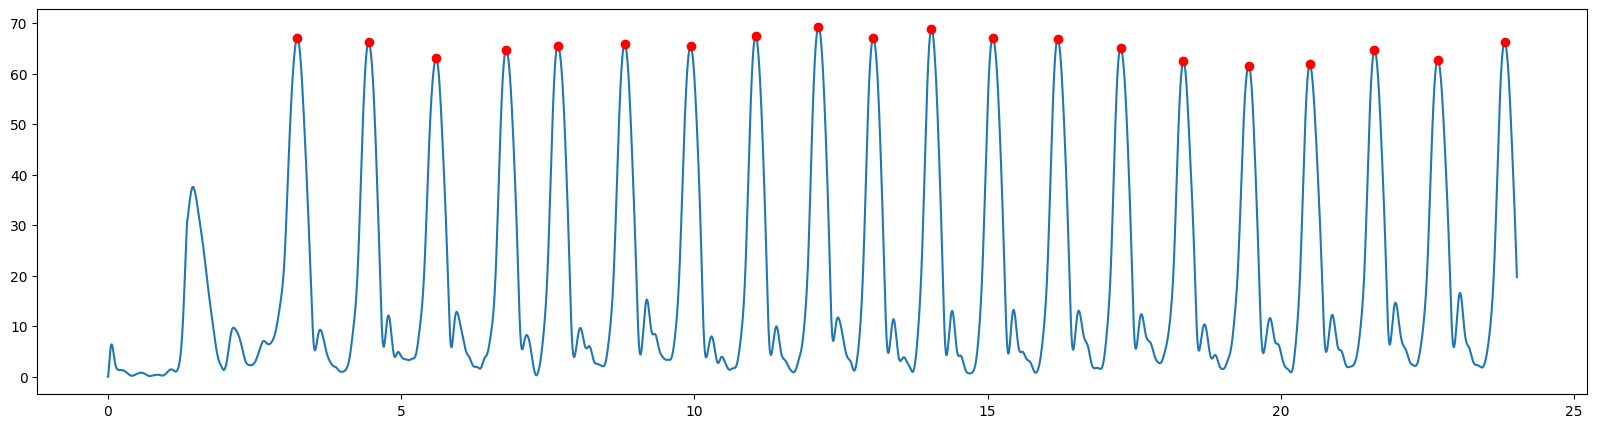

In [7]:
peaks = find_peaks(data_files[0]['Angle'], height=50, distance=125, width=20)
print(peaks[0])
#figura
fig = plt.figure(figsize=(20, 5))
plt.plot(data_files[0]['Elapsed Time'], data_files[0]['Angle'])
plt.plot(peaks[0]/250, data_files[0]['Angle'][peaks[0]], 'ro') 
plt.show()

#### 2.1.2. Visualizar segmentos de la señal de angulo correspondientes a los ciclos de marcha detectados entre las cumbres

Cada segmento se grafica sobre el mismo eje para comparar visualmente los diferentes ciclos de marcha. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


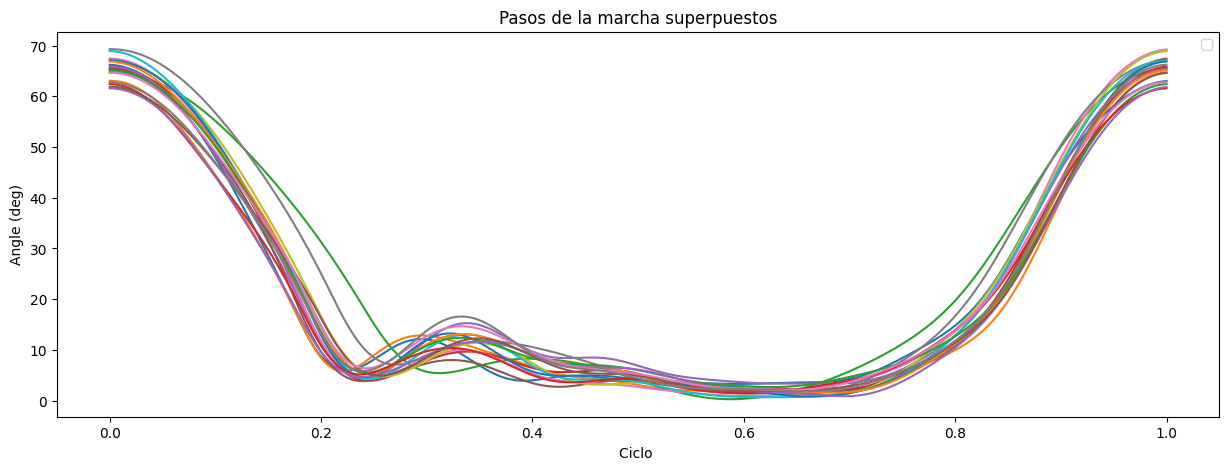

In [8]:
step = [] #almacena segmentos de la señal de angulo

# extrae segmentos de la señal basados en las cumbres
for i in range(1, len(peaks[0])-1):
    step.append(np.array(data_files[0]['Angle'][peaks[0][i]:peaks[0][i+1]]))   

# creacion figura para visualizar
fig = plt.figure(figsize=(15, 5))

#grafico cada segmento de la marcha
for i in range(len(step)):
    t = np.linspace(0, 1, len(step[i]))
    plt.plot(t, step[i])

plt.xlabel('Ciclo ')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('Pasos de la marcha superpuestos')
plt.show()

### 2.2. Preparando datos

In [9]:
# Definicion muscles
muscles = data_files[0].columns[1:-1]   #columnas del df de musculos en datos de EMG


# Inicializar listas
step = [] #pasos
emg = []  #ventanas de EMG normalizadas
file = [] #indice del archivo de origen de cada paso

# Itero sobre archivos de datos
for index, data in enumerate(data_files):

    # Deteccion de cumbres en la señal de angulo (altura min, distancia min entre cumbres, ancho min de la cumbre)
    peaks = find_peaks(data['Angle'], height=50, distance=125, width=20)

    # Extraccion y Normalizacion de ventanas de datos
    for i in range(1, len(peaks[0])-1):
        step.append(np.array(data['Angle'][peaks[0][i]:peaks[0][i+1]]))
        emg_window = data[muscles][peaks[0][i]:peaks[0][i+1]].reset_index(drop=True)
        emg_window = np.array(emg_window)

        # normalize
        emg_window = (emg_window - emg_window.mean())/emg_window.std() # asegura media 0 y std 1 de los datos
        emg.append(emg_window) # un paso normalizado de la marcha
        file.append(index) # archivo al que pertenece el paso

# Convertir de file a un array de numpy
file = np.array(file)

### 2.3 Visualizar datos EMG por 4 musculos diferentes

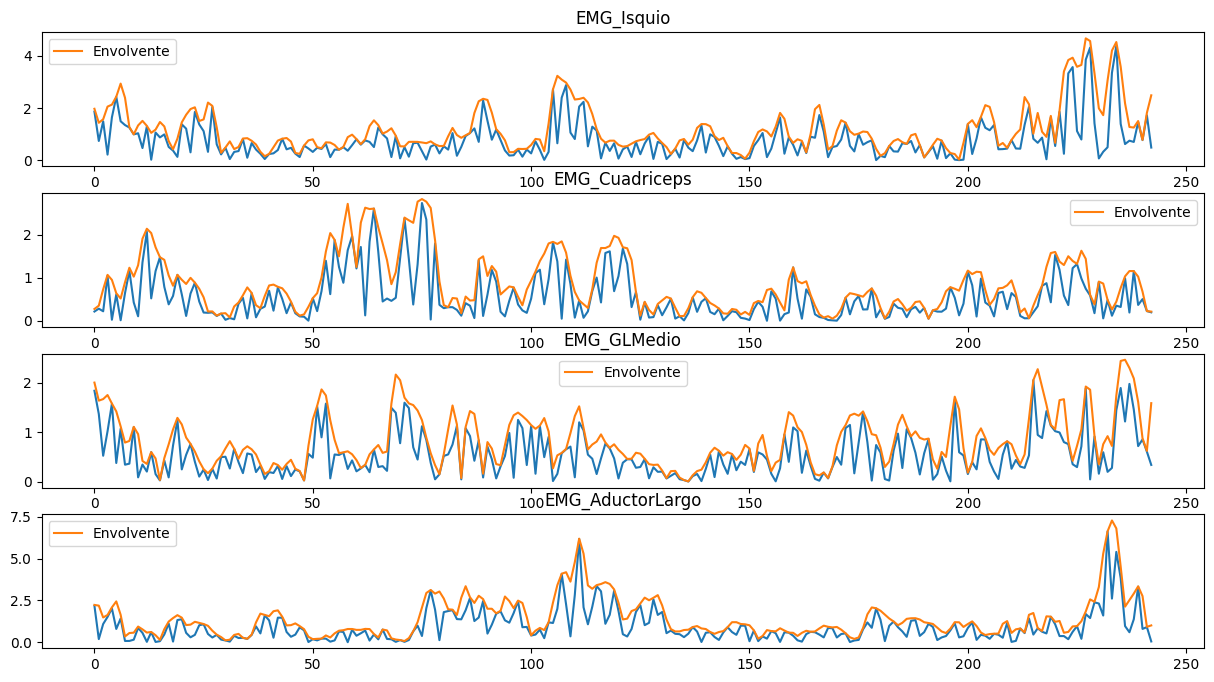

In [10]:
fig,ax = plt.subplots(4, 1, figsize=(15, 8))

# itero sobre ejes para graficar
for i in range(4):
    #grafico señal con rectificacion de onda completa
    ax[i].plot(np.abs(emg_window[:, i]))  # Señal con full wave rectification 
    
    # Calculo de la envolvente usando transformada de hilbert
    env = np.abs(signal.hilbert(emg_window[:, i]))
    ax[i].plot(env, label='Envolvente')
    ax[i].set_title(muscles[i])
    ax[i].legend()

plt.show()

### 2.4. Define feature extraction function


Caracteristicas Dominio del Tiempo
- **RMS (root mean square):** medida enegia señal - refleja act muscular
- **Varianza:** medidad variabilidad señal - indica cambios en act muscular
- **Kurtosis:** info sobre distribucion datos
- **Skewness:** mide asimetria distribucion señal
- **ZC (zero crossing):** numero de veces que señal cruza el eje cero - indicativo de la frecuencia de disparo de los musculos.

Caracterisicas Dominio de la Frecuencia
- **Espectro de potencia:** distribucion potencia de señal en funcion de frecuencia
- **Mediana de la frecuencia:** frecuencia bajo del cual se encuentra el 50% de la potencia del espectro de la señal
- **Frecuencia Media:** promedio ponderado de las frecuencias presentes en la señal
- **cumbre de Frecuencia:** frecuencia con la mayor potencia en el espectro

Caracteristicas de la Envolvente
- **promedios de la envolvente:** 
- **desviacion estandar de la envolvente:**
- **maximos de la envolvente:**
- **minimos de la envolvente:**

Extraer caracteristicas de datos de EMG

In [11]:
# Función para la transformada de Fourier
#cita de libreria balu3 de Domingo Mery balu3.fx.chr, adapte a este entorno
def fourier(signal, Nfourier=64, nfourier=4, norm=False):
    F = np.abs(fft(signal, n=Nfourier))
    f = F[:Nfourier//2]  # Solo la mitad positiva
    f = f[:nfourier]  # Redimensionar si es necesario
    if norm:
        f = f / np.linalg.norm(f)
    return f

In [12]:
def extract_feature(data, C=[0], divide=3):
    result = []
    for c in C:
        signal0 = data[:, c]
        rectified_signal = np.abs(signal0)
        env = np.abs(signal.hilbert(data[:, c]))
        rms = np.sqrt(np.mean(rectified_signal**2))
        var = np.var(rectified_signal)
        kurt = scipy.stats.kurtosis(rectified_signal)
        skew = scipy.stats.skew(rectified_signal)
        zc = ((rectified_signal[:-1] * rectified_signal[1:]) < 0).sum()
        freqs, power_spectrum = scipy.signal.welch(rectified_signal, fs=250)
        median_freq = freqs[np.where(np.cumsum(power_spectrum) >= np.sum(power_spectrum) / 2)[0][0]]
        mean_freq = np.sum(freqs * power_spectrum) / np.sum(power_spectrum)
        peak_freq = freqs[np.argmax(power_spectrum)]
        
        for i in range(divide):
            start = int(i*len(data)/divide)
            end = int((i+1)*len(data)/divide)
            segment_env = env[start:end]
            mean_env = segment_env.mean()
            std_env = segment_env.std()
            max_env = segment_env.max()
            min_env = segment_env.min()
            result.extend([mean_env, std_env, max_env, min_env])
        
        fourier_feats = fourier(rectified_signal)
        result.extend(fourier_feats)
        
    result.extend([rms, var, kurt, skew, zc, median_freq, mean_freq, peak_freq])
    result = np.array(result)
    return result

In [13]:
# itera sobre datos (division en fases, extrae caract para cada fase, etiquetado)
# conversion a arrays
def label_data_and_features(data, C= [0, 1, 2, 3], divide=3):
    features = []
    labels = []
    for e in data:
        T, _ = e.shape
        for i in range(num_fases):
            start = int(i*T/num_fases)
            end = int((i+1)*T/num_fases)
            features.append(extract_feature(e[start:end, :], C=C, divide=divide))
            labels.append(i)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

## 3. Training and testing subsets (definir conjuntos de training y testing)

In [14]:
#Preparacion de datos para entrenamiento y prueba
num_fases = 4
divide = 3      # divide la señal en 4 partes iguales, de cada parte se extrae una característica
C = [ 1, 2, 3]  # Canales a utilizar -> Cuadriceps, GLMedio y Aductor largo
features, labels = label_data_and_features(emg, C, divide)

C:\Users\josef\AppData\Roaming\Python\Python38\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 71, using nperseg = 71
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\josef\AppData\Roaming\Python\Python38\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 72, using nperseg = 72
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\josef\AppData\Roaming\Python\Python38\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 74, using nperseg = 74
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\josef\AppData\Roaming\Python\Python38\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 75, using nperseg = 75
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\josef\AppData\Roaming\P

In [15]:
# example_marcha(), contiene 17 archivos
print('Features: '+str(features.shape[0]) +' samples with '+str(features.shape[1]) +' features')
print(' Classes: '+str(int(np.min(labels)))+'...'+str(int(np.max(labels))))

Features: 1088 samples with 56 features
 Classes: 0...3


## 4. Feature selection/transformation

In [16]:
sclean = clean (features)
features = features[:, sclean]

In [17]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

## 5. Classification

### Codigo KDE

In [18]:
#código de Domingo Mery
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    from https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self

    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Lista Clasificadores

In [19]:
classifiers = {
    'knn                               ': KNeighborsClassifier(n_neighbors=1),
    'knn-3                             ': KNeighborsClassifier(n_neighbors=3),
    'knn-5                             ': KNeighborsClassifier(n_neighbors=5),
    'knn-8                             ': KNeighborsClassifier(n_neighbors=8),
    'knn-9                             ': KNeighborsClassifier(n_neighbors=9),
    'knn-10                            ': KNeighborsClassifier(n_neighbors=10),
    'knn-15                            ': KNeighborsClassifier(n_neighbors=15),
    'knn-20                            ': KNeighborsClassifier(n_neighbors=15),
    'mlp                               ': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'mlp layers 2                      ': MLPClassifier(hidden_layer_sizes=(100, 50), alpha=1, max_iter=1000, random_state=42),
    'svm lineal 1                      ': SVC(kernel='linear', gamma=0.2, C=0.1),
    'svm lineal 2                      ': SVC(kernel='linear', gamma=0.25, C=0.2),
    'svm polinomial                    ': SVC(kernel='poly', gamma=0.2,degree=3, C=0.1),
    'svm rbf 1                         ': SVC(kernel='rbf', gamma=0.2, C=0.1),
    'svm rbf 2                         ': SVC(kernel='rbf', gamma=0.65, C=0.25),
    'svm rbf 3                         ': SVC(kernel="rbf", random_state=42),
    'svm rbf gamma auto                ': SVC(kernel='rbf', gamma='auto'),
    'svm sigmoidal                     ': SVC(kernel='sigmoid', gamma=0.01, C=1.5),
    'dmin                              ': NearestCentroid(),
    'bayes kde                         ': KDEClassifier(bandwidth=1.0),
    'naive bayes                       ': GaussianNB(),
    'lda                               ': LinearDiscriminantAnalysis(),
    'qda                               ': QuadraticDiscriminantAnalysis(),
    'random forest depth 3             ': RandomForestClassifier(max_depth=3,n_estimators=150),
    'random forest depth 15            ': RandomForestClassifier(max_depth=15,n_estimators=150),
    'random forest depth 30            ': RandomForestClassifier(max_depth=30, n_estimators=200),
    'random forest depth 100           ': RandomForestClassifier(max_depth=100,n_estimators=150),
    'random forest n_estimators 300    ': RandomForestClassifier(n_estimators=300),
    'decision tree                     ': DecisionTreeClassifier(max_depth=3),
    'decision tree depth 12            ': DecisionTreeClassifier(max_depth=12),
    'decision tree depth 100           ': DecisionTreeClassifier(max_depth=100),
    'logistic regression lbfgs         ': LogisticRegression(C=0.1,solver="lbfgs"),
    'logistic regression newton-cg     ': LogisticRegression(C=0.2,solver="newton-cg"),
    'gradient boosting                 ': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    'adaboost                          ': AdaBoostClassifier(n_estimators=100),
    'extra trees                       ': ExtraTreesClassifier(n_estimators=100),
    'bagging                           ': BaggingClassifier(n_estimators=50),
    'perceptron                        ': Perceptron(max_iter=1000),
    'sgd                               ': SGDClassifier(max_iter=1000, tol=1e-3)
}

## 6. Evaluation

In [20]:
def crossval(clf,X,y,nfolds=10,show=1):
  scores = cross_val_score(clf, X, y, cv=nfolds)
  acc = np.mean(scores)
  if show:
    acc_st = "{:.2f}".format(acc*100)
    print('Accuracy = '+str(acc_st))
  return acc

Ejemplo de como usarlo

In [21]:
# CROSSVAL
clf = KNeighborsClassifier(n_neighbors=8)
acc = crossval(clf,features,labels)

Accuracy = 74.73


### Sin SFS

In [22]:
# Aplicar validación cruzada a todos los clasificadores
accuracies = {}
for name, clf in classifiers.items():
    print(f"\nEvaluando: {name.strip()}")
    acc = crossval(clf, features, labels, nfolds=10, show=1)
    accuracies[name] = acc

# Imprimir resultados
print("\nPrecisión total por clasificador:")
for name, acc in accuracies.items():
    print(f'{name.strip()}: {acc:.2f}')


Evaluando: knn
Accuracy = 70.04

Evaluando: knn-3
Accuracy = 74.55

Evaluando: knn-5
Accuracy = 74.54

Evaluando: knn-8
Accuracy = 74.73

Evaluando: knn-9
Accuracy = 74.36

Evaluando: knn-10
Accuracy = 74.91

Evaluando: knn-15
Accuracy = 74.27

Evaluando: knn-20
Accuracy = 74.27

Evaluando: mlp
Accuracy = 78.03

Evaluando: mlp layers 2
Accuracy = 78.49

Evaluando: svm lineal 1
Accuracy = 75.74

Evaluando: svm lineal 2
Accuracy = 76.20

Evaluando: svm polinomial
Accuracy = 61.03

Evaluando: svm rbf 1
Accuracy = 73.35

Evaluando: svm rbf 2
Accuracy = 75.92

Evaluando: svm rbf 3
Accuracy = 78.12

Evaluando: svm rbf gamma auto
Accuracy = 73.62

Evaluando: svm sigmoidal
Accuracy = 70.49

Evaluando: dmin
Accuracy = 71.23

Evaluando: bayes kde
Accuracy = 66.82

Evaluando: naive bayes
Accuracy = 72.43

Evaluando: lda
Accuracy = 78.22

Evaluando: qda
Accuracy = 71.96

Evaluando: random forest depth 3
Accuracy = 77.02

Evaluando: random forest depth 15
Accuracy = 79.04

Evaluando: random forest

### Con SFS

In [23]:
sfs_indices = sfs(features, labels, 45) # se pide que sean 50 caracterisitcas
features = features[:,sfs_indices] # Selecciona las columnas de Xtrain
print(sfs_indices)

[40 20 32 48 49 24 29 12 10 45 44  4  2 13 41 35 26 53 36  3 19 33 38 14
 54 25 23  0 42 47  7 50 51 34 28 39  8 27 22 21 30 16 46 18 31]


In [24]:
# Aplicar validación cruzada a todos los clasificadores
accuracies = {}
for name, clf in classifiers.items():
    print(f"\nEvaluando: {name.strip()}")
    acc = crossval(clf, features, labels, nfolds=10, show=1)
    accuracies[name] = acc

# Imprimir resultados
print("\nPrecisión total por clasificador:")
for name, acc in accuracies.items():
    print(f'{name.strip()}: {acc:.2f}')


Evaluando: knn
Accuracy = 70.40

Evaluando: knn-3
Accuracy = 76.65

Evaluando: knn-5
Accuracy = 75.46

Evaluando: knn-8
Accuracy = 75.92

Evaluando: knn-9
Accuracy = 76.02

Evaluando: knn-10
Accuracy = 76.84

Evaluando: knn-15
Accuracy = 75.74

Evaluando: knn-20
Accuracy = 75.74

Evaluando: mlp
Accuracy = 78.68

Evaluando: mlp layers 2
Accuracy = 79.59

Evaluando: svm lineal 1
Accuracy = 75.19

Evaluando: svm lineal 2
Accuracy = 76.19

Evaluando: svm polinomial
Accuracy = 54.96

Evaluando: svm rbf 1
Accuracy = 73.07

Evaluando: svm rbf 2
Accuracy = 76.47

Evaluando: svm rbf 3
Accuracy = 78.49

Evaluando: svm rbf gamma auto
Accuracy = 73.44

Evaluando: svm sigmoidal
Accuracy = 69.67

Evaluando: dmin
Accuracy = 70.77

Evaluando: bayes kde
Accuracy = 67.01

Evaluando: naive bayes
Accuracy = 71.69

Evaluando: lda
Accuracy = 78.13

Evaluando: qda
Accuracy = 73.16

Evaluando: random forest depth 3
Accuracy = 76.47

Evaluando: random forest depth 15
Accuracy = 77.76

Evaluando: random forest

### Otra forma de calcular Validacion Cruzada

In [25]:
'''# 1. Definición del Clasificador
clf = KNeighborsClassifier(n_neighbors=8)

# 2. Definición de los "Folds"
nfolds = 10
skf = StratifiedKFold(n_splits=nfolds,shuffle=True) # Estratificado
#skf = KFold(n_splits=nfolds,shuffle=True)          # No-Estratificado

# 3. Evaluación de la Validación Cruzada
scores = cross_val_score(clf, features, labels, cv=skf)

# 4. Promedio de los "Accuracies"
acc = np.mean(scores)
std = np.std(scores)
acc_st = "{:.2f} +/- {:.2f}".format(acc*100,std*100)
print('Accuracy (CV'+str(nfolds)+')= '+str(acc_st))'''

'# 1. Definición del Clasificador\nclf = KNeighborsClassifier(n_neighbors=8)\n\n# 2. Definición de los "Folds"\nnfolds = 10\nskf = StratifiedKFold(n_splits=nfolds,shuffle=True) # Estratificado\n#skf = KFold(n_splits=nfolds,shuffle=True)          # No-Estratificado\n\n# 3. Evaluación de la Validación Cruzada\nscores = cross_val_score(clf, features, labels, cv=skf)\n\n# 4. Promedio de los "Accuracies"\nacc = np.mean(scores)\nstd = np.std(scores)\nacc_st = "{:.2f} +/- {:.2f}".format(acc*100,std*100)\nprint(\'Accuracy (CV\'+str(nfolds)+\')= \'+str(acc_st))'